In [1]:
import os
import glob
import numpy as np
import pandas as pd
import radio
from radio.batchflow import FilesIndex, Dataset, Pipeline
from radio import CTImagesMaskedBatch as CTIMB
from radio_utils import show_slices, get_nodules_pixel_coords, num_of_cancerous_pixels

from config import config
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [32, 32]

# import utils
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/home/paul/.local/lib/python3.6/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
PATH_TO_FOLDER = config['preprocess_result_path']

path_to_scans_sample = os.path.join(PATH_TO_FOLDER, '*.mhd')
luna_index = FilesIndex(path=path_to_scans_sample, no_ext=True)
lunaset = Dataset(index=luna_index, batch_class=CTIMB)
len(luna_index.indices)

884

In [3]:
# %%time

# from pp_utils import load_itk_image
# xlist = []
# ylist = []
# zlist = []
# filelist = [f for f in os.listdir(PATH_TO_FOLDER) if f.endswith('.mhd') ]
# for file in filelist:
#     scan_or, origin, spacing, isflip = load_itk_image(os.path.join(PATH_TO_FOLDER,file))
#     (xx,yy,zz) = scan_or.shape
#     xlist.append(xx)
#     ylist.append(yy)
#     zlist.append(zz)
# #     print(xx,yy,zz)
# print(max(xlist), max(ylist), max(zlist))
# # 378 397 400 48sec

In [4]:
filelist = [f.split('_label.npy')[0] for f in os.listdir(PATH_TO_FOLDER) if f.endswith('_label.npy') ]

columns_df = ['coordZ', 'coordY', 'coordX', 'diameter_mm', 'seriesuid']
columns_temp = ['coordZ', 'coordY', 'coordX', 'diameter_mm']
nodules_df = pd.DataFrame([], columns=columns_temp)

for file in filelist:
    annot = np.load(os.path.join(PATH_TO_FOLDER, file + '_label.npy'), allow_pickle=True)
    if not np.all(annot == [[0,0,0,0]]):
        temp = pd.DataFrame(annot, columns=columns_temp)
        temp['seriesuid'] = file
        nodules_df = pd.concat([nodules_df, temp])
print(len(nodules_df))
print(nodules_df.head())

1184
    coordX   coordY   coordZ diameter_mm  \
0  244.401  256.747  189.289       15.27   
1  296.347  282.068  179.572     9.51432   
2  285.103  280.647  208.734     8.22038   
3   253.87   234.24  274.573     12.9969   
4  270.862   273.24  159.134     12.1396   

                                           seriesuid  
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518...  
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518...  
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518...  
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518...  
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518...  


In [21]:
SHAPE = (378, 397, 400)
np.random.seed(42)

preprocessing = (Pipeline()
                .load(fmt='raw')
                .fetch_nodules_info(nodules_df)
                .create_mask()
                .unify_spacing(spacing=(1.,1.,1.), shape=SHAPE)
                .rotate(angle=90, axes=(1,2), random=True)
                .sample_nodules(batch_size=None, nodule_size=(64, 64, 64), share=(1), variance=(36,36,36)))

In [6]:
# crops_sampling_pipeline = preprocessing.sample_nodules(batch_size=8, nodule_size=(64, 64, 64), share=(0.5))

In [22]:
batch_crops = (lunaset >> preprocessing).next_batch(2, shuffle=False)
num_of_cancerous_pixels(batch_crops)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 223 and the array at index 1 has size 175

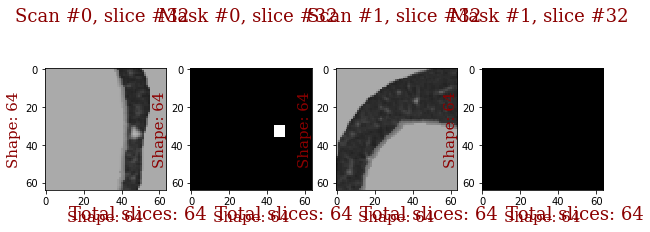

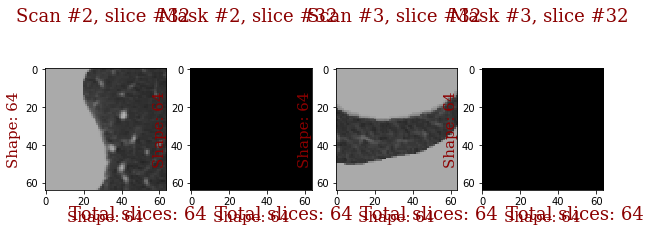

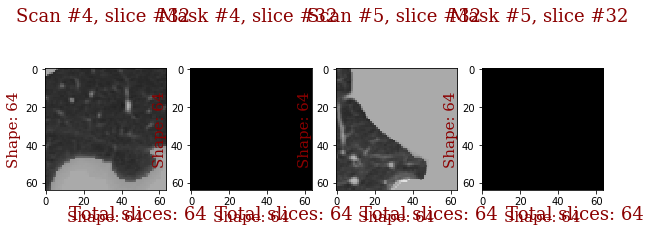

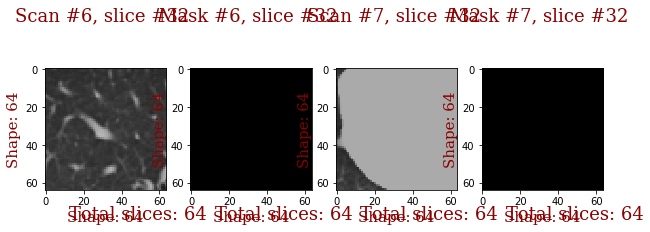

In [8]:
show_slices(batch_crops, [0, 0, 1, 1], 32, components=['images', 'masks'], clims=[(0, 255), (0, 1)], grid=False)
show_slices(batch_crops, [2, 2, 3, 3], 32, components=['images', 'masks'], clims=[(0, 255), (0, 1)], grid=False)
show_slices(batch_crops, [4,4,5,5], 32, components=['images', 'masks'], clims=[(0, 255), (0, 1)], grid=False)
show_slices(batch_crops, [6,6,7,7], 32, components=['images', 'masks'], clims=[(0, 255), (0, 1)], grid=False)

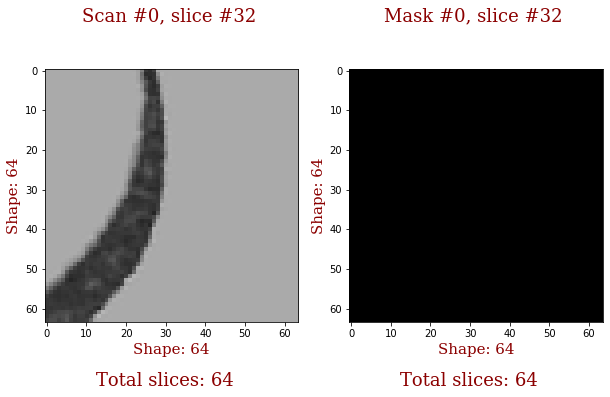

In [19]:
show_slices(batch_crops, [0, 0], 32, components=['images', 'masks'], clims=[(0, 255), (0, 1)], grid=False)